# Deep Image Prior + Diffusion Prior

by [@nousr](https://twitter.com/nousr_)


---


**Special Thanks**
* [LAION](https://discord.gg/uPMftTmrvS) for support, resources, and community

* [@RiversHaveWings](https://twitter.com/RiversHaveWings) for making me aware of this technique

* [Stability AI](https://stability.ai/) for compute which makes these models possible

* [lucidrains](https://github.com/lucidrains) for spearheading the open-source replication of DALLE 2

--


> Note: if this notebook says it requires high-ram you should be able to safely ignore that. the ViT-B/32 prior will comfortably work in google colab

# Setup

In [ ]:
!nvidia-smi

Fri Jun 24 21:15:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## repos

In [ ]:
#@title
!git clone https://github.com/nousr/DALLE2-pytorch.git; cd DALLE2-pytorch; pip install .; cd .. # use the latest repo for ViT-L finetune
# !git clone https://github.com/nousr/DALLE2-pytorch.git; cd DALLE2-pytorch; git checkout checkpoints; pip install .; cd .. # for vit-b/32
!pip install git+https://github.com/nousr/deep-image-prior.git
!pip install madgrad
!pip install einops

## models

In [ ]:
#@title
# !wget 'https://huggingface.co/zenglishuci/conditioned-prior/resolve/main/vit-b-32/ema641.pth' -O prior_B.pth
!wget 'https://huggingface.co/zenglishuci/conditioned-prior/resolve/main/vit-l-14/prior_aes_finetune.pth' -O prior_L.pth # un-comment for larger model! (should fit in normie colab)

## imports

In [ ]:
#@title
import argparse
from collections import namedtuple
from copy import deepcopy
import io
import json
import gc
import math
import pickle
import random
import sys
import time

from einops import rearrange
import kornia.augmentation as K
from madgrad import MADGRAD
import numpy as np
import requests
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from tqdm import trange, tqdm

from dalle2_pytorch import DiffusionPrior, DiffusionPriorNetwork,OpenAIClipAdapter, DiffusionPriorTrainer

import clip

from deep_image_prior.models import *
from deep_image_prior.utils.sr_utils import *
from resize_right import resize

device = "cuda:0"

## helpers

In [ ]:
#@title
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


def clamp(x, min_value, max_value):
    return max(min(x, max_value), min_value)


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        # self.cut_pow = cut_pow
        self.augs = T.Compose([
            K.RandomHorizontalFlip(p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.8, padding_mode='border', resample='bilinear'),
            K.RandomPerspective(0.4, p=0.7, resample='bilinear'),
            K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.7),
            K.RandomGrayscale(p=0.15),
        ])

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        long_size, short_size = max(sideX, sideY), min(sideX, sideY)
        min_size = min(short_size, self.cut_size)
        pad_x, pad_y = long_size - sideX, long_size - sideY
        input_zero_padded = F.pad(input, (pad_x, pad_x, pad_y, pad_y), 'constant')
        input_mask = F.pad(torch.zeros_like(input), (pad_x, pad_x, pad_y, pad_y), 'constant', 1.)
        input_padded = input_zero_padded + input_mask * input.mean(dim=[2, 3], keepdim=True)
        cutouts = []
        for cn in range(self.cutn):
            if cn >= self.cutn - self.cutn // 4:
                size = long_size
            else:
                size = clamp(int(short_size * torch.zeros([]).normal_(mean=.8, std=.3)), min_size, long_size)
            # size = int(torch.rand([])**self.cut_pow * (short_size - min_size) + min_size)
            offsetx = torch.randint(min(0, sideX - size), abs(sideX - size) + 1, ()) + pad_x
            offsety = torch.randint(min(0, sideY - size), abs(sideY - size) + 1, ()) + pad_y
            cutout = input_padded[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
            cutouts.append(resize(cutout, out_shape=(self.cut_size, self.cut_size),by_convs=True, pad_mode='reflect'))
        return self.augs(torch.cat(cutouts))


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

class CaptureOutput:
    """Captures a layer's output activations using a forward hook."""

    def __init__(self, module):
        self.output = None
        self.handle = module.register_forward_hook(self)

    def __call__(self, module, input, output):
        self.output = output

    def __del__(self):
        self.handle.remove()

    def get_output(self):
        return self.output

def load_dip(input_depth, num_scales, offset_type, device):
    dip_net = get_hq_skip_net(
        input_depth,
        skip_n33d=192,
        skip_n33u=192,
        skip_n11=4,
        num_scales=num_scales,
        offset_type=offset_type
    ).to(device)

    return dip_net

def load_diffusion_model(dprior_path, clip_choice="ViT-B/32"):
    
    clip_model = OpenAIClipAdapter(clip_choice)

    if clip_choice == "ViT-B/32":
      print("loading ViT-B/32...", end="")
      prior_network = DiffusionPriorNetwork(
          dim=512,
          depth=12,
          dim_head=64,
          heads=16,
          normformer=True,
          attn_dropout=5e-2,
          ff_dropout=5e-2,
          num_time_embeds=1,
          num_image_embeds=1,
          num_text_embeds=1,
          num_timesteps=100,
          ff_mult=4
      )
      
      diffusion_prior = DiffusionPrior(
          net=prior_network,
          clip=clip_model,
          image_embed_dim=512,
          timesteps=100,
          cond_drop_prob=0.1,
          loss_type="l2",
          condition_on_text_encodings=True,

      )
      
    elif clip_choice == "ViT-L/14":
      print("loading ViT-L/14...hang tight...", end="")
      prior_network = DiffusionPriorNetwork(
        dim=768,
        depth=24,
        dim_head=64,
        heads=32,
        normformer=True,
        attn_dropout=5e-2,
        ff_dropout=5e-2,
        num_time_embeds=1,
        num_image_embeds=1,
        num_text_embeds=1,
        num_timesteps=1000,
        ff_mult=4
      )

      diffusion_prior = DiffusionPrior(
          net=prior_network,
          clip=clip_model,
          image_embed_dim=768,
          timesteps=1000,
          cond_drop_prob=0.1,
          loss_type="l2",
          condition_on_text_encodings=True,

      )

    # this will load the entire trainer
    # If you only want EMA weights for inference you will need to extract them yourself for now 
    # (if you beat me to writing a nice function for that please make a PR on Github!)
    trainer = DiffusionPriorTrainer(
        diffusion_prior=diffusion_prior,
        lr=1.1e-4,
        wd=6.02e-2,
        max_grad_norm=0.5,
        amp=False,
        group_wd_params=True,
        use_ema=True,
        device=device,
        accelerator=None,
    )

    trainer.load(dprior_path)

    return trainer

# model loading

In [ ]:
#@title Model Selection
clip_choice = "ViT-L/14" #@param ["ViT-L/14", "ViT-B/32"]

dpiror = "prior_L.pth" if clip_choice == "ViT-L/14" else "prior_B.pth"
prior = load_diffusion_model(dprior_path=dpiror, clip_choice=clip_choice).to(device).eval().requires_grad_(False)

print("loaded model!")

# Initialize DIP skip network
input_depth = 32
clip_model = prior.diffusion_prior.clip.clip
clip_size = clip_model.visual.input_resolution
normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                        std=[0.26862954, 0.26130258, 0.27577711])

100%|███████████████████████████████████████| 933M/933M [00:09<00:00, 96.8MiB/s]


loading ViT-L/14...hang tight...loading saved diffusion prior at version 0.11.3 but current package version is at 0.11.5
Overriding LR to be 0.00011
Loaded model
loaded model!


# generation params

In [ ]:
# -- DEEP IMAGE PRIOR CONFIG
offset_type = 'none'
num_scales = 6  # adjust this by +/- 1 every time you change your output size by a factor of 2! (i.e. 6 for 256x256, 7 for 512x512)
size= [256,256] # multiples of 8
input_noise_strength=0
lr = 1e-3 # no clue what this should be for ViT-L/14
offset_lr_fac = 1.0
lr_decay= 0.995
param_noise_strength = 0.0
display_freq = 25
cutn = 16
make_cutouts = MakeCutouts(clip_size, cutn)
iterations = 250
param_noise_strength = 0.0

# -- PRIOR CONFIG
cond_scale = 1.00
num_samples_per_batch = 2

Using device: cuda


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/resize_right/resize_right.py:194: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  - in_sz + 1)  # (5)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 10%|▉         | 24/250 [00:24<03:30,  1.07it/s]

i: 25, loss: 0.21549, losses: 0.21549


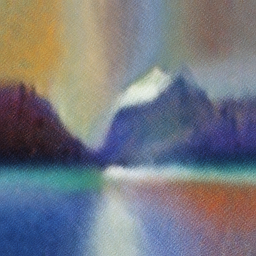

 20%|█▉        | 49/250 [00:47<03:03,  1.10it/s]

i: 50, loss: 0.123963, losses: 0.123963


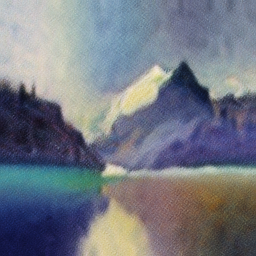

 30%|██▉       | 74/250 [01:10<02:45,  1.07it/s]

i: 75, loss: 0.121788, losses: 0.121788


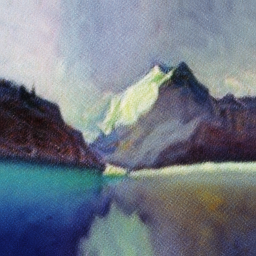

 40%|███▉      | 99/250 [01:33<02:21,  1.07it/s]

i: 100, loss: 0.100456, losses: 0.100456


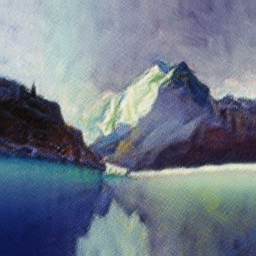

 50%|████▉     | 124/250 [01:57<01:57,  1.07it/s]

i: 125, loss: 0.0943017, losses: 0.0943017


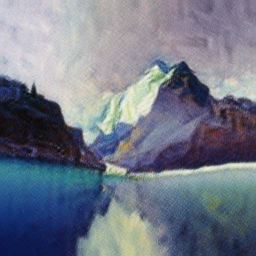

 60%|█████▉    | 149/250 [02:20<01:33,  1.08it/s]

i: 150, loss: 0.0955494, losses: 0.0955494


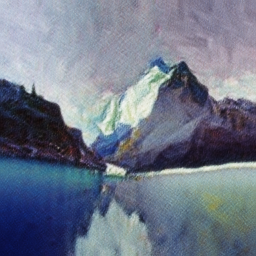

 70%|██████▉   | 174/250 [02:43<01:09,  1.09it/s]

i: 175, loss: 0.0785921, losses: 0.0785921


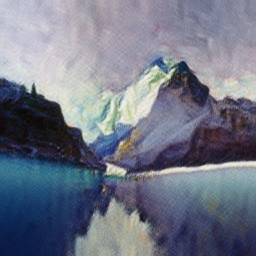

 80%|███████▉  | 199/250 [03:06<00:46,  1.09it/s]

i: 200, loss: 0.0750041, losses: 0.0750041


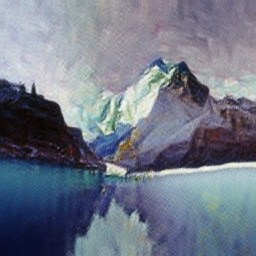

 90%|████████▉ | 224/250 [03:29<00:24,  1.08it/s]

i: 225, loss: 0.0837503, losses: 0.0837503


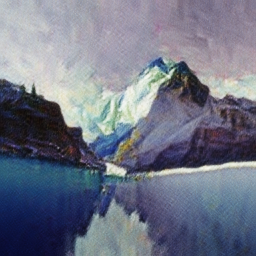

100%|█████████▉| 249/250 [03:53<00:00,  1.07it/s]

i: 250, loss: 0.0687269, losses: 0.0687269


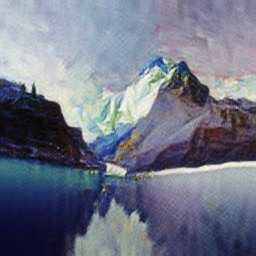

100%|██████████| 250/250 [03:53<00:00,  1.07it/s]


In [ ]:
#@title Generate
prompt = "An oil painting of mountains, in the style of monet" #@param {type:"string"}

net = load_dip(input_depth=input_depth,
                num_scales=num_scales, offset_type=offset_type, device=device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

seed = random.randint(0,100000) * random.randint(0,1000)

optimizer_type = 'MADGRAD'  # Adam, MADGRAD

sideX, sideY = size  # Resolution

itt = 0

# Initialize input noise
input_scale = 0.1
net_input = torch.randn([1, input_depth, sideY, sideX], device=device)

tokenized_text = clip.tokenize(prompt).to(device)
noise = torch.randn((1,512))
t = torch.linspace(1, 0, 1000 + 1)[:-1]


target_embed = prior.sample(tokenized_text, num_samples_per_batch=num_samples_per_batch, cond_scale=cond_scale)

prompts = [Prompt(target_embed)]

params = [{'params': get_non_offset_params(net), 'lr': lr},
          {'params': get_offset_params(net), 'lr': lr * offset_lr_fac}]

if optimizer_type == 'Adam':
    opt = optim.Adam(params, lr)
elif optimizer_type == 'MADGRAD':
    opt = MADGRAD(params, lr, momentum=0.9)
scaler = torch.cuda.amp.GradScaler()
image = None
try:
    for _ in trange(iterations, leave=True, position=0):
        opt.zero_grad(set_to_none=True)

        noise_ramp = 1 - min(1, itt / iterations)
        net_input_noised = net_input
        if input_noise_strength:
            phi = min(1, noise_ramp * input_noise_strength) * math.pi / 2
            noise = torch.randn_like(net_input)
            net_input_noised = net_input * math.cos(phi) + noise * math.sin(phi)

        with torch.cuda.amp.autocast():
            out = net(net_input_noised * input_scale).float()

        losses = []
        # for i, clip_model in enumerate(clip_models):
        cutouts = normalize(make_cutouts(out))
        with torch.cuda.amp.autocast(False):
            image_embeds = clip_model.encode_image(cutouts).float()
        for prompt in prompts:
            losses.append(prompt(image_embeds))  # * clip_model.weight)

        loss = sum(losses, out.new_zeros([]))

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        if param_noise_strength:
            with torch.no_grad():
                noise_ramp = 1 - min(1, itt / iterations)
                for group in opt.param_groups:
                    for param in group['params']:
                        param += torch.randn_like(param) * group['lr'] * param_noise_strength * noise_ramp

        itt += 1

        if itt % display_freq == 0 :
            with torch.inference_mode():
                image = TF.to_pil_image(out[0].clamp(0, 1))
                if itt % display_freq == 0:
                    losses_str = ', '.join([f'{loss.item():g}' for loss in losses])
                    tqdm.write(f'i: {itt}, loss: {loss.item():g}, losses: {losses_str}')
                    image.save(f'out_{itt:05}.png')
                    display(image, display_id=1)
        for group in opt.param_groups:
            group['lr'] = lr_decay * group['lr']

except KeyboardInterrupt:
    torch.cuda.empty_cache()
    gc.collect()
    pass